In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction to PyTorch

In the last exercise we discussed the mechanisms of gradient backpropagation and implemented the corresponding functionality in the ``toolbox`` module. This exercise introduces PyTorch, a Deep Learning framework providing powerful tools for simple and efficient implementations of neural networks.

First, we need to import the corresponding Python module:

In [3]:
import torch

The basic building block of PyTorch are Tensors, which behave very similar to the class ``toolbox.Tensor`` from last week. Tensors can be initialized by passing a NumPy array or by calling dedicated functions with syntax similar to NumPy:

In [4]:
a = torch.tensor(np.array([[1., 2.], [3., 4.]]))
b = torch.ones(2, 2)
c = torch.empty(5)

In [5]:
print(a)
print(b)
print(c)

tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
tensor([[1., 1.],
        [1., 1.]])
tensor([-3.2278e-27,  4.5890e-41, -3.2278e-27,  4.5890e-41,  0.0000e+00])


PyTorch features the same mechanism for gradient backpropagation as developed in last week's exercise and even provides the same attribute names:
- ``data`` stores the internal data of the tensor representing its value.
- ``requires_grad`` specifies if the tensor participates in the build-up of the computation graph.
- ``grad`` keeps a tensor storing the gradient of the last backpropagation for leaf nodes of the graph with ``requires_grad=True``.
- ``grad_fn`` points to the operation generating the tensor; ``None`` if the tensor is a leaf node.

Again, the backpropagation is initiated by calling ``backward`` on a tensor.

In [6]:
a = torch.tensor(1., requires_grad=True)
b = torch.tensor(2.)

In [7]:
c = a + b
d = c + a
d = d * d

In [8]:
d.backward()

/home/nd/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
print(a.grad)
print(b.grad)
print(c.grad_fn)
print(d.grad_fn)

tensor(16.)
None


Again, computation graphs will not be held alive causing errors when calling ``backward`` multiple times:

In [10]:
try:
    d.backward()
except:
    print("Not working...")

Not working...


## Inference

At inference time one usually does not want to bulild up the computation graph for calculating the gradients as it's computationally expensive and bears the danger of memory leakage. Therefore PyTorch provides the context manager ``torch.no_grad`` for disabling gradient computations:

In [11]:
a = torch.tensor(1., requires_grad=True)
b = torch.tensor(2.)

with torch.no_grad():
    c = a + b

try:
    c.backward()
except:
    print("Not working...")

Not working...


## CUDA [Only works on systems with a GPU - not required for the graded task]

Until now, all computations in this exercise class were carried out on a CPU. The hardware of choice for Deep Learning applications, however, are GPUs. The high amount of parallelization and efficient calculation of simple operations on GPUs are highly beneficial for training and inference in artificial neural networks. Therefore, all major Deep Learning frameworks offer the possibility of utilizing GPUs.

In PyTorch we can move a tensor to the GPU by simply calling the function ``cuda`` returning a pointer to the tensor. The device of a tensor can be determined using the ``device`` attribute.

In [12]:
a = torch.tensor(2.)
print(a.device)

cpu


In [13]:
a = a.cuda()
print(a.device)

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In the above output, ``cuda`` means that the tensor is located on a GPU and the number after the colon specifies the device among all available GPUs.

## Data sets

Data are one driving force in the field of machine learning and therefore it is important to deal with data properly. Luckily, PyTorch provides some handy tools which make the treatment of data very easy. The base class for representing data sets is ``torch.utils.data.Dataset``. This class overloads the functions ``__len__`` and ``__getitem__`` which allow us to easily access data contained in the set as we know it for example from Pythons lists.

PyTorch already comprises wrapper classes for some poular data sets in ``torchvision.datasets``. To get started, we will use the MNIST data set of handwritten digits from LeCun et al. http://yann.lecun.com/exdb/mnist/. The argument ``transform`` below forces the data to be converted to PyTorch Tensors.

In [14]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [15]:
train_set = MNIST('data', download=True, transform=transforms.ToTensor())
test_set = MNIST('data', train=False, transform=transforms.ToTensor())

In [16]:
print(len(train_set))
print(len(test_set))

60000
10000


The single elements of these data sets are tuples containing an image representing a handwritten digit stored as an array in a PyTorch Tensor and the corresponding value of the digit as label.

In [17]:
el = train_set[5]
print(type(el))
print(el[0].shape)
print(el[1])

<class 'tuple'>
torch.Size([1, 28, 28])
2


So we know the value of the digit represented in the image is 5. We can show the corresponding image using ``matplotlib.pyplot.imshow``.

Text(0.5, 1.0, 'Label: 2')

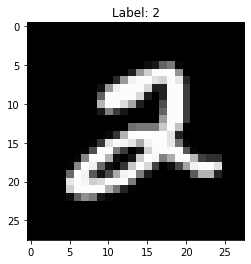

In [18]:
plt.imshow(el[0][0], cmap='gray', vmin=0., vmax=1.)
plt.title('Label: {}'.format(el[1]))

Note that ``imshow`` requires grayscale images to be of size $H\times W$ but ``el`` is of size $1\times H \times W$. The reason therefor is that images are in general represented as $C \times H \times W$ arrays, where $C$ denotes the number of channels of the image. For color images $C$ typically amounts to $3$, for grayscale images to $1$.

## Data loaders

Equally important as the data itself is the process of loading it efficiently to the processing unit. PyTorch provides an easy interface for tackling this problem. Most of the time, we also want mini-batches of data rather than single elements of our data set. The class ``DataLoader`` from ``torch.utils.data`` takes care of this and we only have to provide the data set and define the batch size. Additionally, we may specify further arguments like whether we want the data to be shuffled or the number of workers involved in the process of loading the data.

In [19]:
from torch.utils.data import DataLoader

In [20]:
train_loader = DataLoader(train_set, batch_size=4, num_workers=4, shuffle=True)

Let's have a look at one of the mini-batches:

In [21]:
batch = next(iter(train_loader))

data = batch[0]
labels = batch[1]

In [22]:
print(type(batch))
print(batch[0].shape)

<class 'list'>
torch.Size([4, 1, 28, 28])


The shape of the array has increased by the first dimension related to the differnt batch elements, i.e. the general shape for images in mini-batches is $B \times C \times H \times W$ where $B$ is the batch size. Let's visualize the images of this mini-batch:

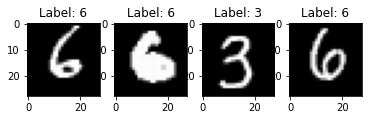

In [23]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(data[i, 0], cmap='gray', vmin=0., vmax=1.)
    plt.title('Label: {}'.format(labels[i]))

Note that the elements are randomly shuffled each time we iterate over the data loader.

## Network

Similar to our ``toolbox.Module``, PyTorch defines ``Module`` in ``torch.nn`` which serves as base class for neural networks and their layers. For defining a network, you have to inherit from ``torch.nn.Module`` and define the ``forward`` function. Furthermore, ``torch.nn`` provides you with a broad variety of pre-implemented tools and layers you can use in your network. To get a first impression, have a look at the code below:

In [24]:
import torch.nn as nn

In [25]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28, 20)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

Let's go through this: In the constructor we instantiate a couple of layers we want to use in the forward pass. For the linear layer we have to specifty the input and output dimensions of our linear transformations. The batch sizes usually are excluded from these size considerations as the data is procesed separately for each element in the mini-batch. To shed light on this mechanism, consider ``layer3``. It expects inputs of size $B \times 20$, multiplies each element of the batch with a matrix of size $10 \times 20$ (and possibly adds some vector afterwards) and outputs the transformed data of size $B \times 10$.

In order to be able to pass an image to a linear layer, we have to resize the image with the dimensions $B \times C \times H \times W$ to a vector of size $B \times \left( C \cdot H \cdot W \right)$. The forward pass of an object of type ``torch.nn.Module`` can be performed by simply calling the object itself like this:

In [26]:
network = SimpleNet()

In [27]:
with torch.no_grad():
    output = network(batch[0])
print(output.shape)

torch.Size([4, 10])


In [28]:
_, pred_labels = output.max(dim=1)

print(pred_labels)
print(labels)

tensor([4, 5, 5, 0])
tensor([6, 6, 3, 6])


We have set the output of the last layer to be of size ten as we want to predict one out of ten labels. We would like our network to assign the highest value of the output on the coordinate corresponding to the correct label. As discussed earlier, the cross entropy loss is suitable for classification tasks penalizing high output values on the wrong labels.

In [29]:
loss_fun = nn.CrossEntropyLoss()

In [30]:
loss = loss_fun(output, labels)
print(loss)

tensor(2.2952)


## Parameters

As soon as it comes to training, we want to modify the network's parameters in order to decrease the loss on the training set. We can access the learnable parameters of a network by calling its ``parameters`` function.

In [31]:
params = network.parameters()

In [32]:
for param in params:
    print(param.shape)

torch.Size([20, 784])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])


In our case the parameters of the network are the weights and biases of the two linear layers.

## Adding multiple layers to a network

As the number of layers increases, adding every single layer to the attribute list of the network and explicitly iterating over them in the forward pass can be tedious. A convenient alternative in this case is PyTorch's container class ``torch.nn.Sequential`` which allows you to condense multiple layers into a single ``Module`` object. The usage is straight-forward as you can see in the following example:

In [33]:
class SimpleNet2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(28*28, 20), nn.ReLU(), nn.Linear(20, 10))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.layers(x)
        return x

**NOTE:** It is not sufficient to store the network's layers in a list as we did in our own ``Network`` class from the second last exercise class. Even though you would still be able to perform a forward pass, the layers are not registered as submodules of the network object and therefore their parameters can't be accessed using the ``parameters`` function.

## Training on GPU [Only works on systems with a GPU - not required for the graded task]

In order to perform training or inference of a network on a GPU we have to move the data as well as the network itself to the GPU. This again works by simply calling the ``cuda`` function.

In [34]:
data, labels = data.cuda(), labels.cuda()
network = network.cuda()

with torch.no_grad():
    output = network(data)
    loss = loss_fun(output, labels)

print(output.device)
print(loss.device)

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [35]:
network.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0180, -0.0032, -0.0235,  ..., -0.0234,  0.0325,  0.0269],
                      [ 0.0331,  0.0111, -0.0251,  ..., -0.0300, -0.0019, -0.0023],
                      [-0.0307,  0.0024, -0.0093,  ...,  0.0210, -0.0235, -0.0034],
                      ...,
                      [-0.0343,  0.0355, -0.0173,  ...,  0.0289, -0.0342,  0.0285],
                      [ 0.0161,  0.0300, -0.0286,  ..., -0.0151,  0.0016, -0.0013],
                      [ 0.0238,  0.0201, -0.0129,  ...,  0.0290, -0.0168,  0.0326]])),
             ('layer1.bias',
              tensor([ 0.0177,  0.0153,  0.0143, -0.0350,  0.0199,  0.0352,  0.0164,  0.0203,
                       0.0351,  0.0059, -0.0277,  0.0115, -0.0072,  0.0356,  0.0087, -0.0245,
                      -0.0040, -0.0093,  0.0154,  0.0222])),
             ('layer3.weight',
              tensor([[ 0.0605, -0.1465, -0.1627, -0.1682, -0.0690, -0.0533, -0.0840,  0.1670,
                        0.1996,

In [36]:
list(network.parameters())

[Parameter containing:
 tensor([[ 0.0180, -0.0032, -0.0235,  ..., -0.0234,  0.0325,  0.0269],
         [ 0.0331,  0.0111, -0.0251,  ..., -0.0300, -0.0019, -0.0023],
         [-0.0307,  0.0024, -0.0093,  ...,  0.0210, -0.0235, -0.0034],
         ...,
         [-0.0343,  0.0355, -0.0173,  ...,  0.0289, -0.0342,  0.0285],
         [ 0.0161,  0.0300, -0.0286,  ..., -0.0151,  0.0016, -0.0013],
         [ 0.0238,  0.0201, -0.0129,  ...,  0.0290, -0.0168,  0.0326]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0177,  0.0153,  0.0143, -0.0350,  0.0199,  0.0352,  0.0164,  0.0203,
          0.0351,  0.0059, -0.0277,  0.0115, -0.0072,  0.0356,  0.0087, -0.0245,
         -0.0040, -0.0093,  0.0154,  0.0222], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0605, -0.1465, -0.1627, -0.1682, -0.0690, -0.0533, -0.0840,  0.1670,
           0.1996, -0.0960, -0.0618, -0.0120,  0.2038,  0.1335, -0.1685, -0.0122,
          -0.1245, -0.1617,  0.0574,  0.0253],
         [-0.1894,  0

# Training a network using SGD [2 points]

Implement SGD in ``optimizer.py`` as introduced in the lecture and do not use the SGD optimizer included in PyTorch. Test your implementation by running the cell below:

In [41]:
from optimizer import SGD

net = SimpleNet2()

net.load_state_dict(torch.load('net_params'))

batch = next(iter(DataLoader(train_set, batch_size=4)))

op = net(batch[0])

l = loss_fun(op, batch[1])

l.backward()

optim = SGD(net.parameters())

optim.step()

state_dict = net.state_dict()
target_state_dict = torch.load('net_params_updated')

for key in state_dict:
    assert (state_dict[key] - target_state_dict[key]).abs().max() < 1e-6 # 1 point

optim.zero_grad()

for param in net.parameters():
    assert param.grad.abs().max() == 0 # 1 point